In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


## 確認裝置

In [79]:
# 1. 裝置設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用裝置：{device}")

使用裝置：cuda:0


## 下載資料集

In [80]:
# 2. 資料前處理與載入
transform = transforms.Compose([
    transforms.ToTensor(),  # 直接將像素從 [0,255] => [0,1]
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [81]:

class CNN2(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        act = nn.ReLU()  # 或改成 nn.GELU()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # 32x32 -> 32x32
            #nn.BatchNorm2d(64),
            act,
            nn.MaxPool2d(2, 2)                           # 32x32 -> 16x16
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),# 16x16 -> 16x16
            #nn.BatchNorm2d(128),
            act,
            nn.MaxPool2d(2, 2)                           # 16x16 -> 8x8
        )

        self.gap = nn.AdaptiveAvgPool2d(1)  # 8x8 -> 1x1
        self.fc1 = nn.Linear(64, num_classes)
        #self.fc1 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.block1(x)   # (B,64,16,16)
        #x = self.block2(x)   # (B,128,8,8)
        x = self.gap(x)      # (B,256,1,1)
        x = x.view(x.size(0), -1)  # (B,256)
        x = self.fc1(x)      # (B,num_classes)
        return x
    
model2 = CNN2().to(device)
print(model2)

# 4. 損失與優化器
criterion = nn.CrossEntropyLoss()  # 直接接收整數標籤
optimizer = optim.Adam(model2.parameters(), lr=0.001)


CNN2(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gap): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=64, out_features=10, bias=True)
)


Epoch 1/10 — Train Loss: 2.1344, Train Acc: 0.2046 — Val Loss: 2.0336, Val Acc: 0.2546
Epoch 2/10 — Train Loss: 1.9740, Train Acc: 0.2772 — Val Loss: 1.9130, Val Acc: 0.3040
Epoch 3/10 — Train Loss: 1.8877, Train Acc: 0.3057 — Val Loss: 1.8512, Val Acc: 0.3348
Epoch 4/10 — Train Loss: 1.8348, Train Acc: 0.3221 — Val Loss: 1.8035, Val Acc: 0.3361
Epoch 5/10 — Train Loss: 1.8003, Train Acc: 0.3358 — Val Loss: 1.7733, Val Acc: 0.3483
Epoch 6/10 — Train Loss: 1.7745, Train Acc: 0.3440 — Val Loss: 1.7596, Val Acc: 0.3423
Epoch 7/10 — Train Loss: 1.7585, Train Acc: 0.3481 — Val Loss: 1.7374, Val Acc: 0.3609
Epoch 8/10 — Train Loss: 1.7449, Train Acc: 0.3522 — Val Loss: 1.7299, Val Acc: 0.3632
Epoch 9/10 — Train Loss: 1.7349, Train Acc: 0.3567 — Val Loss: 1.7183, Val Acc: 0.3666
Epoch 10/10 — Train Loss: 1.7260, Train Acc: 0.3589 — Val Loss: 1.7219, Val Acc: 0.3608


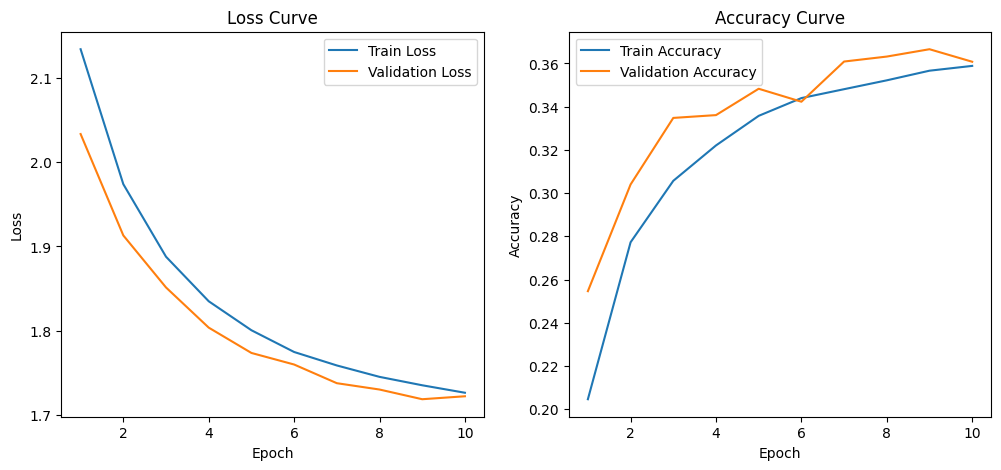

In [82]:
import matplotlib.pyplot as plt

num_epochs = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):
    # ====== 訓練 ======
    model2.train()
    running_loss = 0.0
    correct, total = 0, 0

    for imgs, labels in trainloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # ====== 驗證 ======
    model2.eval()
    val_running_loss = 0.0
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for imgs, labels in testloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model2(imgs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_loss = val_running_loss / len(testloader.dataset)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}/{num_epochs} — "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} — "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# ====== 畫 Loss 曲線 ======
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# ====== 畫 Accuracy 曲線 ======
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()
